In [1]:
# =====================================================================
# Script: plot_contours_gridded_from_xyz.py
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plan-view contouring from scattered XYZ by gridding + interpolation.
#   Supports line or filled contours, optional basemap, and overlay of
#   original points. Designed for JupyterBook lessons.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_contours_gridded_from_xyz(
    filename,
    sep='\t',
    # levels: pass explicit list, or define start/stop/step, or None to auto
    levels=None,
    level_start=None, level_stop=None, level_step=None,
    nx=200, ny=200,
    method='cubic',                # 'linear'|'cubic'|'nearest'
    fillna='nearest',              # None|'nearest'
    filled=False,                  # False: contour lines; True: filled
    cmap='terrain',
    show_points=True,
    point_size=6, point_color='k',
    basemap_path=None,             # e.g., "SomewhereUSABaseMap.png"
    basemap_extent=None,           # (xmin, xmax, ymin, ymax) if using basemap
    title=None,
    ax=None
):
    """
    Plot plan-view contours by first interpolating scattered XYZ onto a grid.

    Parameters
    ----------
    filename : str
        Path to text file with columns 'X-Easting', 'Y-Northing', 'Z-Elevation'.
    sep : str, optional
        Column delimiter (default tab).
    levels : sequence of float, optional
        Explicit contour levels. If None, will use (level_start, level_stop, level_step)
        if provided, else auto-generate 10 levels from data range.
    level_start, level_stop, level_step : float, optional
        Convenience to build levels = np.arange(start, stop+step, step).
    nx, ny : int
        Grid resolution in X and Y.
    method : {'linear','cubic','nearest'}
        griddata interpolation method.
    fillna : {None,'nearest'}
        Fill NaNs after interpolation (useful near convex hull edges).
    filled : bool
        If True, use filled contours (contourf); else contour lines.
    cmap : str
        Matplotlib colormap for filled contours.
    show_points : bool
        Overlay original survey points.
    point_size : float
        Marker size for original points.
    point_color : str
        Color for original points.
    basemap_path : str or None
        Optional raster image path to show under contours.
    basemap_extent : tuple or None
        Extent (xmin, xmax, ymin, ymax) for basemap.
    title : str or None
        Plot title; defaults to 'Contour Plot from <filename>'.
    ax : matplotlib Axes or None
        Axes to draw into. If None, a new figure/axes is created.

    Returns
    -------
    Xg, Yg, Zg, cs, ax : ndarray, ndarray, ndarray, QuadContourSet, Axes
        Gridded coordinates/values, the contour set, and the axes.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load data ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()
    xy = np.column_stack([x, y])

    # --- Build grid ---
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xg, Yg = np.meshgrid(xi, yi)

    # --- Interpolate to grid ---
    Zg = griddata(xy, z, (Xg, Yg), method=method)
    if fillna == 'nearest':
        mask = np.isnan(Zg)
        if mask.any():
            Zg[mask] = griddata(xy, z, (Xg, Yg), method='nearest')[mask]

    # --- Levels logic ---
    if levels is None:
        if (level_start is not None) and (level_stop is not None) and (level_step is not None):
            levels = np.arange(level_start, level_stop + 0.5 * level_step, level_step, dtype=float)
        else:
            zmin = np.nanmin(Zg); zmax = np.nanmax(Zg)
            levels = np.linspace(zmin, zmax, 10)

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 6.5))
        created_fig = True
    else:
        fig = ax.get_figure()

    # Optional basemap
    if basemap_path is not None:
        im = plt.imread(basemap_path)
        if basemap_extent is None:
            basemap_extent = (x.min(), x.max(), y.min(), y.max())
        ax.imshow(im, extent=basemap_extent, origin='upper')

    # Contours
    if filled:
        cs = ax.contourf(Xg, Yg, Zg, levels=levels, cmap=cmap)
        cb = fig.colorbar(cs, ax=ax, shrink=0.85, pad=0.02)
        cb.set_label('Z')
    else:
        cs = ax.contour(Xg, Yg, Zg, levels=levels, linewidths=1.25, colors='k')
        ax.clabel(cs, inline=True, fontsize=10)

    if show_points:
        ax.scatter(x, y, s=point_size, c=point_color, label='Survey Points')
        ax.legend(loc='lower right')

    ax.set_title(title or f'Contour Plot from {filename}')
    ax.set_xlabel('X Coordinate (Easting)')
    ax.set_ylabel('Y Coordinate (Northing)')
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return Xg, Yg, Zg, cs, ax


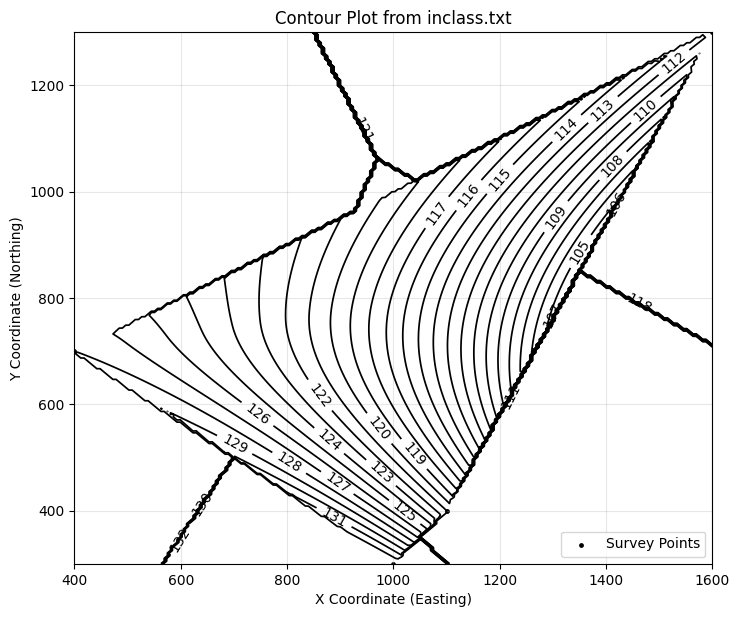

In [2]:
# Gridded, filled contours with explicit levels
Xg, Yg, Zg, cs, ax = plot_contours_gridded_from_xyz(
    'inclass.txt',
    filled=False, cmap='terrain',
    level_start=100, level_stop=150, level_step=1,
    show_points=True
)